## Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
import os

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed=42
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

### Загрузка данных

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, cache = True)
mnist.target = mnist.target.astype(np.int8)

In [3]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target,i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target,i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
    
sort_by_target(mnist)

### Просмотр данных

In [4]:
mnist['data'], mnist['target']

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [5]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


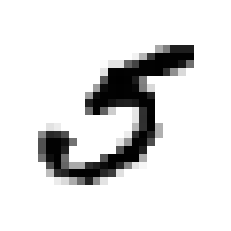

In [6]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [7]:
y[36000]

5

In [8]:
def plot_digit(data):
    image=data.reshape(28,28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis(False)

In [9]:
def plot_digits(instances,images_per_row=10, **options):
    size=28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis('off')

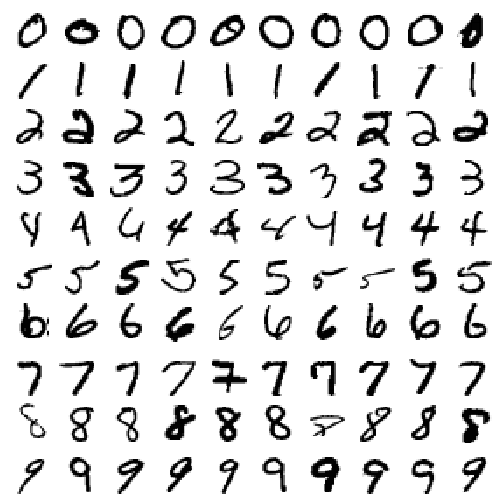

In [10]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row = 10)
plt.show()

### Создание тестового и испытательного набора

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Обучение Двоичного классификатора

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=2)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=2, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

## Оценка производительности

### Перекрестная проверка

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.95325
0.96655
0.9524


In [17]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95325, 0.96655, 0.9524 ])

In [18]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91055, 0.90895, 0.90945])

### Матрица неточностей

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False,  True, False, ..., False, False,  True])

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52983,  1596],
       [  960,  4461]], dtype=int64)

### Точность и полнота

In [21]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.7365032194155523
0.8229109020475927


In [22]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7773131207527444

### Соотношение точность/полнота

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2998.24372086])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold = 7000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [27]:
from sklearn.metrics import precision_recall_curve

precision, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

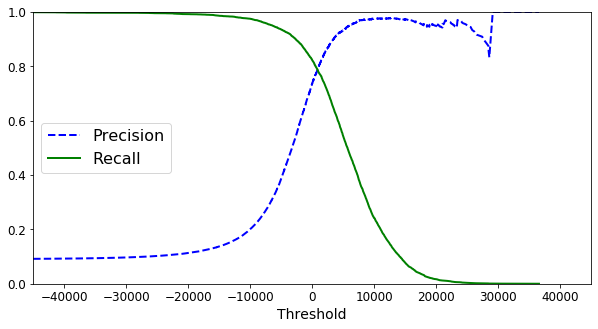

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
    plt.xlabel('Threshold')
    plt.legend(loc='center left',fontsize=16)
    plt.ylim([0,1])
    plt.xlim([-45000,45000])
    
plt.figure(figsize=(10,5))
plot_precision_recall_vs_threshold(precision, recalls, thresholds)
plt.show()

In [29]:
# Показывает, что для всех распознанных 5-ок количество очков > 0
# а для всех остальных цифр, распознанных как не 5 - количество очков отрицательное.
(y_train_pred == (y_scores > 0)).all()

True

In [30]:
y_train_pred_90 = (y_scores > 1000)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.7961219879518072
0.7801143700424276


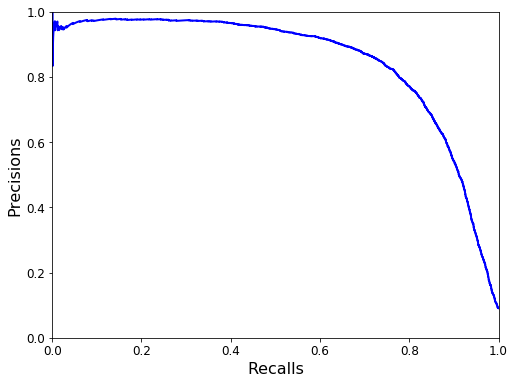

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recalls', fontsize=16)
    plt.ylabel('Precisions', fontsize=16)
    plt.axis([0, 1, 0, 1])
    
plt.figure(figsize=(8,6))
plot_precision_vs_recall(precision, recalls)
plt.show()

## Кривая ROC

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

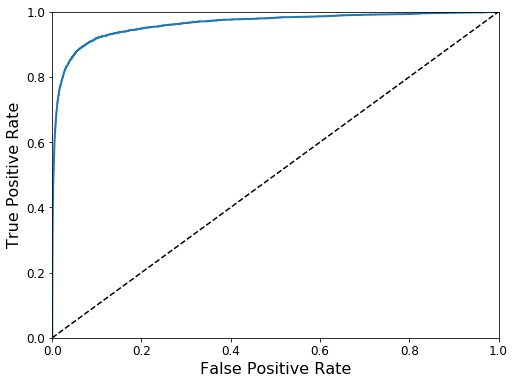

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.962739827629755

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=2)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [36]:
y_probas_forest

array([[0.98, 0.02],
       [0.94, 0.06],
       [1.  , 0.  ],
       ...,
       [0.73, 0.27],
       [1.  , 0.  ],
       [0.1 , 0.9 ]])

In [37]:
y_scores_forest = y_probas_forest[:, 1]
y_scores_forest

array([0.02, 0.06, 0.  , ..., 0.27, 0.  , 0.9 ])

In [38]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

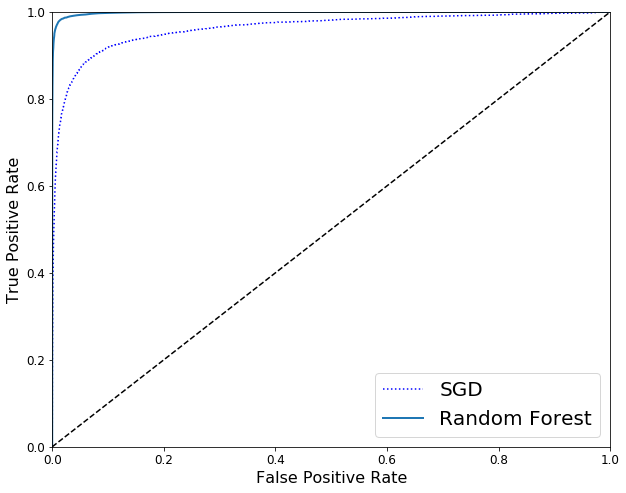

In [39]:
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right', fontsize=20)
plt.axis([0, 1, 0, 1])
plt.show()

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9985480701182091

In [41]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
y_train_pred_forest

array([False, False, False, ..., False, False,  True])

In [42]:
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9893439197659841
0.8734550820881756


In [43]:
cross_val_score(forest_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9882 , 0.98785, 0.9871 ])

In [44]:
forest_clf.fit(X_train, y_train_5)
forest_clf.score(X_train, y_train_5)

1.0

## Многоклассовая классифокация

In [45]:
# Классифаер

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [46]:
some_digits_scores = sgd_clf.decision_function([some_digit])
some_digits_scores

array([[ -2133.97629477, -20902.91463759, -12335.21107413,
         -1974.58131364, -13846.69986364,   3572.41296429,
        -17511.07018316, -18153.53376497, -12463.80317157,
        -14625.35557976]])

In [47]:
np.argmax(some_digits_scores)

5

In [48]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [49]:
sgd_clf.classes_[5]

5

In [50]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=2))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [51]:
len(ovo_clf.estimators_)

45

In [52]:
# Случайные Леса

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [53]:
print(forest_clf.base_estimator_,
      forest_clf.classes_,
      forest_clf.n_features_,
      forest_clf.n_outputs_, sep='\n')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
[0 1 2 3 4 5 6 7 8 9]
784
1


In [54]:
print(forest_clf.get_params(),
      forest_clf.predict_proba([some_digit]),
      forest_clf.score(X_train, y_train), sep='\n\n')

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 2, 'verbose': 0, 'warm_start': False}

[[0.02 0.   0.03 0.09 0.   0.83 0.   0.   0.02 0.01]]

1.0


In [55]:
# Оценочки

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy', verbose=6)

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.862, total= 1.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] .................................... , score=0.867, total= 1.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s


[CV] .................................... , score=0.884, total= 1.2min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.9min finished


array([0.8615 , 0.86715, 0.8838 ])

In [56]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring='accuracy', verbose=6)

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.968, total=  25.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.8s remaining:    0.0s


[CV] .................................... , score=0.966, total=  25.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   51.7s remaining:    0.0s


[CV] .................................... , score=0.964, total=  25.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min finished


array([0.96765, 0.96575, 0.9642 ])

In [57]:
# Масштабирование

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

D:\anacondaz\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\anacondaz\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90395, 0.9002 , 0.9065 ])

In [58]:
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring='accuracy',verbose=6)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.968, total=  25.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.7s remaining:    0.0s


[CV] .................................... , score=0.966, total=  25.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   51.6s remaining:    0.0s


[CV] .................................... , score=0.964, total=  25.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min finished


array([0.9678, 0.9659, 0.9642])

## Анализ ошибок

In [59]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_m = confusion_matrix(y_train, y_train_pred)
conf_m

D:\anacondaz\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\anacondaz\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5611,    0,   16,    6,    8,   49,   31,    6,  195,    1],
       [   0, 6421,   45,   24,    3,   43,    6,    7,  180,   13],
       [  28,   28, 5279,  102,   67,   24,   66,   42,  311,   11],
       [  27,   21,  115, 5283,    0,  215,   29,   45,  331,   65],
       [  13,   14,   51,   15, 5247,   11,   40,   25,  260,  166],
       [  27,   19,   32,  167,   54, 4530,   80,   15,  425,   72],
       [  28,   17,   55,    2,   40,  102, 5553,    8,  113,    0],
       [  16,   15,   55,   27,   55,   15,    4, 5718,  144,  216],
       [  18,   63,   45,   99,    3,  133,   34,   11, 5398,   47],
       [  21,   19,   31,   70,  129,   41,    1,  165,  299, 5173]],
      dtype=int64)

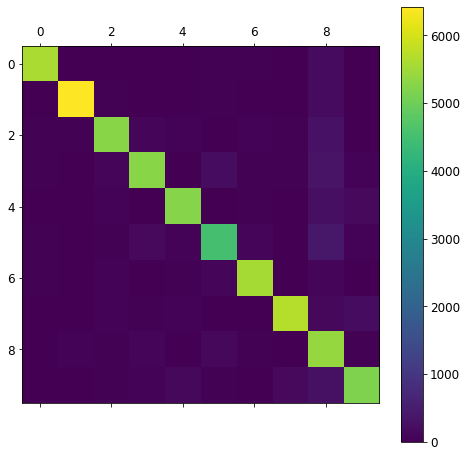

In [60]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
plot_confusion_matrix(conf_m)

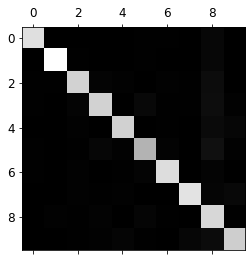

In [61]:
plt.matshow(conf_m, cmap=plt.cm.gray)
plt.show()

In [62]:
row_sums = conf_m.sum(axis=1, keepdims=True)
norm_conf_mx = conf_m / row_sums

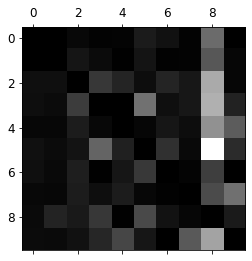

In [63]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

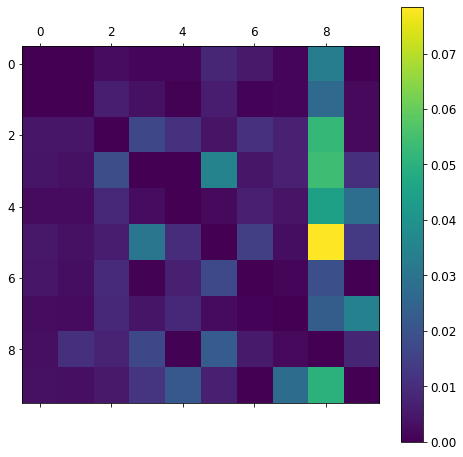

In [64]:
plot_confusion_matrix(norm_conf_mx)

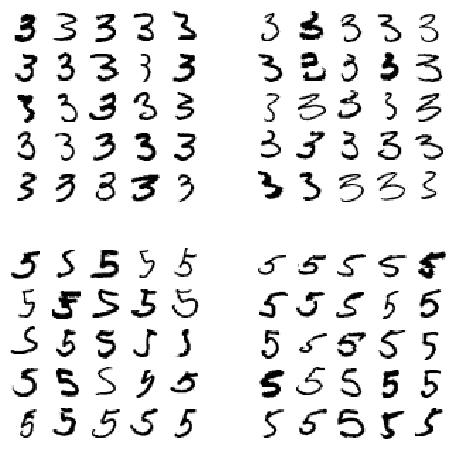

In [65]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Многозначная классификация

In [66]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [67]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [68]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, verbose=6)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 18.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 37.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 55.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 55.4min finished


0.9772483125407345

## Многовыходовая классификация

In [69]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

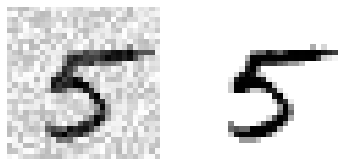

In [70]:
some_index=5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

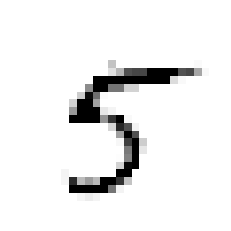

In [71]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## Best Clasifier

In [72]:
from sklearn.model_selection import GridSearchCV

knn_clf = KNeighborsClassifier()
params = [
          {'n_neighbors' : [3, 4, 5],
          'weights' : ['uniform', 'distance']},
]

grid_search = GridSearchCV(knn_clf, params, scoring='accuracy', cv=3, verbose=8)
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_neighbors=3, weights=uniform, score=0.944, total=17.1min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 17.1min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.942, total=17.1min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 34.2min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.941, total=17.1min
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 51.3min remaining:    0.0s


[CV] ..... n_neighbors=3, weights=distance, score=0.946, total=17.1min
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 68.4min remaining:    0.0s


[CV] ..... n_neighbors=3, weights=distance, score=0.944, total=17.1min
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 85.5min remaining:    0.0s


[CV] ..... n_neighbors=3, weights=distance, score=0.942, total=17.1min
[CV] n_neighbors=4, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 102.6min remaining:    0.0s


[CV] ...... n_neighbors=4, weights=uniform, score=0.941, total=17.3min
[CV] n_neighbors=4, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 119.8min remaining:    0.0s


[CV] ...... n_neighbors=4, weights=uniform, score=0.942, total=17.2min
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ...... n_neighbors=4, weights=uniform, score=0.940, total=17.2min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.948, total=17.2min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.946, total=17.2min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.945, total=17.2min
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.944, total=17.1min
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.941, total=16.7min
[CV] n_neighbors=5, weights=uniform ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 306.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=8)

In [73]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [74]:
grid_search.cv_results_

{'mean_fit_time': array([16.46917065, 16.50470606, 16.54619511, 16.51568476, 15.88358196,
        15.52048564]),
 'std_fit_time': array([0.05706377, 0.00879354, 0.1413434 , 0.17924257, 0.41363102,
        0.04796109]),
 'mean_score_time': array([1009.2949845 , 1009.01087578, 1017.93342749, 1016.71846819,
         990.72496041,  983.3753314 ]),
 'std_score_time': array([ 0.89498116,  1.40771812,  0.60180579,  0.82062484, 13.00901697,
         0.11447234]),
 'param_n_neighbors': masked_array(data=[3, 3, 4, 4, 5, 5],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance',
                    'uniform', 'distance'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3, 'weights': 'uniform'},
  {'n_neighbors': 3, 'weights': 'distance'},
  {'n_neighbors': 4, 'we

In [75]:
final_model = grid_search.best_estimator_
final_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [76]:
grid_search.best_score_

0.9460000000000001

In [77]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.9421666666666667 {'n_neighbors': 3, 'weights': 'uniform'}
0.944 {'n_neighbors': 3, 'weights': 'distance'}
0.9405999999999999 {'n_neighbors': 4, 'weights': 'uniform'}
0.9460000000000001 {'n_neighbors': 4, 'weights': 'distance'}
0.94135 {'n_neighbors': 5, 'weights': 'uniform'}
0.9434333333333335 {'n_neighbors': 5, 'weights': 'distance'}


In [78]:
# Не скалированный набор
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_neighbors=3, weights=uniform, score=0.970, total=17.7min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 17.7min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.971, total=17.8min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 35.5min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.968, total=17.7min
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 53.2min remaining:    0.0s


[CV] ..... n_neighbors=3, weights=distance, score=0.971, total=17.7min
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 71.0min remaining:    0.0s


[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=17.8min
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 88.8min remaining:    0.0s


[CV] ..... n_neighbors=3, weights=distance, score=0.969, total=17.7min
[CV] n_neighbors=4, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 106.5min remaining:    0.0s


[CV] ...... n_neighbors=4, weights=uniform, score=0.969, total=17.7min
[CV] n_neighbors=4, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 124.2min remaining:    0.0s


[CV] ...... n_neighbors=4, weights=uniform, score=0.968, total=17.7min
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ...... n_neighbors=4, weights=uniform, score=0.966, total=17.7min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.972, total=17.7min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.973, total=17.7min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.971, total=17.8min
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.969, total=17.7min
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.969, total=17.8min
[CV] n_neighbors=5, weights=uniform ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 319.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=8)

In [79]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [80]:
grid_search.cv_results_

{'mean_fit_time': array([16.11689091, 16.2282602 , 16.09993672, 16.15910951, 16.17673119,
        16.26549395]),
 'std_fit_time': array([0.0329366 , 0.01716486, 0.05681023, 0.06539372, 0.07779631,
        0.15645059]),
 'mean_score_time': array([1048.57273165, 1048.8720746 , 1048.19451269, 1048.7178723 ,
        1048.25573421, 1047.59052769]),
 'std_score_time': array([1.71534815, 1.75229303, 0.32029458, 0.93433936, 0.95199836,
        1.89936848]),
 'param_n_neighbors': masked_array(data=[3, 3, 4, 4, 5, 5],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance',
                    'uniform', 'distance'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3, 'weights': 'uniform'},
  {'n_neighbors': 3, 'weights': 'distance'},
  {'n_neighbors': 4, 'weights'

In [81]:
final_model = grid_search.best_estimator_
final_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [82]:
grid_search.best_score_

0.9718666666666667

In [83]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.9694166666666666 {'n_neighbors': 3, 'weights': 'uniform'}
0.9707666666666667 {'n_neighbors': 3, 'weights': 'distance'}
0.9676999999999999 {'n_neighbors': 4, 'weights': 'uniform'}
0.9718666666666667 {'n_neighbors': 4, 'weights': 'distance'}
0.9685 {'n_neighbors': 5, 'weights': 'uniform'}
0.9699666666666666 {'n_neighbors': 5, 'weights': 'distance'}


In [84]:
from sklearn.externals import joblib

my_model = grid_search.best_estimator_
joblib.dump(my_model,'my_model.pkl')

D:\anacondaz\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['my_model.pkl']

In [85]:
# Рандомные леса

rnd_forest = RandomForestClassifier(random_state=2)

f_params=[
    {'n_estimators':[80, 110, 140, 170, 200, 250, 300, 350],
     'criterion':['gini', 'entropy'],
     'bootstrap':[True, False],
     'class_weight':['balanced', 'balanced_subsample', None]}
]

grid_search = GridSearchCV(rnd_forest, f_params, scoring='accuracy', cv=3, verbose=8)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=80 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=80, score=0.966, total=  20.3s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=80 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.3s remaining:    0.0s


[CV]  bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=80, score=0.966, total=  20.0s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=80 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.3s remaining:    0.0s


[CV]  bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=80, score=0.962, total=  19.6s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=110 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   60.0s remaining:    0.0s


[CV]  bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=110, score=0.968, total=  26.7s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=110 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


[CV]  bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=110, score=0.966, total=  27.4s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=110 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min remaining:    0.0s


[CV]  bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=110, score=0.965, total=  27.0s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=140 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.4min remaining:    0.0s


[CV]  bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=140, score=0.968, total=  34.4s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=140 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.9min remaining:    0.0s


[CV]  bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=140, score=0.967, total=  34.5s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=140 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=140, score=0.965, total=  34.2s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=170 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=170, score=0.969, total=  41.2s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=170 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=170, score=0.968, total=  41.3s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=170 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=170, score=0.965, total=  40.6s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=200 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=200, s

[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=gini, n_estimators=110, score=0.968, total=  28.0s
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini, n_estimators=110 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=gini, n_estimators=110, score=0.966, total=  27.9s
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini, n_estimators=110 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=gini, n_estimators=110, score=0.964, total=  28.0s
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini, n_estimators=140 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=gini, n_estimators=140, score=0.969, total=  35.6s
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini, n_estimators=140 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=gini, n_estimators=140, score=0.967, total=  35.5s
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini

[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=entropy, n_estimators=300, score=0.966, total= 1.7min
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=entropy, n_estimators=300 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=entropy, n_estimators=300, score=0.966, total= 1.8min
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=entropy, n_estimators=350 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=entropy, n_estimators=350, score=0.968, total= 2.4min
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=entropy, n_estimators=350 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=entropy, n_estimators=350, score=0.966, total= 2.4min
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=entropy, n_estimators=350 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=entropy, n_estimators=350, score=0.965, total= 2.4min
[CV] bootstrap=True, class_weight=None, c

[CV]  bootstrap=True, class_weight=None, criterion=entropy, n_estimators=250, score=0.965, total= 1.4min
[CV] bootstrap=True, class_weight=None, criterion=entropy, n_estimators=300 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, n_estimators=300, score=0.968, total= 1.7min
[CV] bootstrap=True, class_weight=None, criterion=entropy, n_estimators=300 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, n_estimators=300, score=0.967, total= 1.7min
[CV] bootstrap=True, class_weight=None, criterion=entropy, n_estimators=300 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, n_estimators=300, score=0.965, total= 1.7min
[CV] bootstrap=True, class_weight=None, criterion=entropy, n_estimators=350 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, n_estimators=350, score=0.968, total= 2.0min
[CV] bootstrap=True, class_weight=None, criterion=entropy, n_estimators=350 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, n_estimators=350, score=0.967,

[CV]  bootstrap=False, class_weight=balanced, criterion=entropy, n_estimators=200, score=0.970, total= 1.8min
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, n_estimators=200 
[CV]  bootstrap=False, class_weight=balanced, criterion=entropy, n_estimators=200, score=0.968, total= 1.8min
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, n_estimators=250 
[CV]  bootstrap=False, class_weight=balanced, criterion=entropy, n_estimators=250, score=0.972, total= 2.2min
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, n_estimators=250 
[CV]  bootstrap=False, class_weight=balanced, criterion=entropy, n_estimators=250, score=0.970, total= 2.3min
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, n_estimators=250 
[CV]  bootstrap=False, class_weight=balanced, criterion=entropy, n_estimators=250, score=0.968, total= 2.2min
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, n_estimators=300 
[CV]  bootstrap=False, class_weight=bala

[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=entropy, n_estimators=140, score=0.972, total= 1.3min
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=entropy, n_estimators=140 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=entropy, n_estimators=140, score=0.970, total= 1.3min
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=entropy, n_estimators=140 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=entropy, n_estimators=140, score=0.968, total= 1.2min
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=entropy, n_estimators=170 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=entropy, n_estimators=170, score=0.972, total= 1.5min
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=entropy, n_estimators=170 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=entropy, n_estimators=170, score=0.970, total= 1.5min
[CV] bootstrap=False, class_weig

[CV]  bootstrap=False, class_weight=None, criterion=entropy, n_estimators=80, score=0.968, total=  44.2s
[CV] bootstrap=False, class_weight=None, criterion=entropy, n_estimators=80 
[CV]  bootstrap=False, class_weight=None, criterion=entropy, n_estimators=80, score=0.967, total=  42.9s
[CV] bootstrap=False, class_weight=None, criterion=entropy, n_estimators=110 
[CV]  bootstrap=False, class_weight=None, criterion=entropy, n_estimators=110, score=0.972, total= 1.0min
[CV] bootstrap=False, class_weight=None, criterion=entropy, n_estimators=110 
[CV]  bootstrap=False, class_weight=None, criterion=entropy, n_estimators=110, score=0.969, total=  58.4s
[CV] bootstrap=False, class_weight=None, criterion=entropy, n_estimators=110 
[CV]  bootstrap=False, class_weight=None, criterion=entropy, n_estimators=110, score=0.968, total= 1.2min
[CV] bootstrap=False, class_weight=None, criterion=entropy, n_estimators=140 
[CV]  bootstrap=False, class_weight=None, criterion=entropy, n_estimators=140, scor

[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed: 397.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=2,
                                   

In [86]:
grid_search.best_params_

{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'n_estimators': 300}

In [87]:
grid_search.cv_results_

{'mean_fit_time': array([ 19.36985636,  26.20457578,  33.31125522,  39.82216461,
         46.76793345,  58.5055546 ,  70.16997965,  81.8638219 ,
         24.3056821 ,  33.57160242,  42.24139468,  51.16927195,
         60.13258298,  75.41395315,  89.99463288, 104.86584361,
         19.75582457,  27.1556987 ,  34.45949594,  41.47838871,
         49.09039752,  61.18307583,  73.58687758,  86.3787636 ,
         25.15338723,  34.34749381,  44.096054  ,  53.17776235,
         62.65541283,  78.48052772,  99.68661833, 141.48323162,
         25.29515553,  31.35008486,  42.27547312,  50.1717337 ,
         59.96534483,  74.7641561 ,  85.98047678, 104.42788442,
         30.33956552,  39.69774779,  47.22741501,  57.31338922,
         69.61069115,  83.56542691,  97.64344128, 120.20161549,
         37.59804487,  49.54446769,  59.47694612,  74.18806338,
         85.57334979, 103.1296157 , 140.43977038, 153.18640701,
         46.51275563,  60.8261168 ,  75.48546084,  90.11775859,
        105.81490922, 1

In [88]:
grid_search.best_score_

0.9712500000000001

In [89]:
final_model = grid_search.best_estimator_
final_model

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [90]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.9648 {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 80}
0.9662333333333334 {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 110}
0.96665 {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 140}
0.9669666666666666 {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 170}
0.9671833333333333 {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 200}
0.9673333333333334 {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 250}
0.96735 {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 300}
0.9675666666666666 {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 350}
0.9641000000000001 {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 80}
0.9655333333333332 {'bootstrap': True, 'class_weight

### Оценка на испытательном наборе

In [91]:
f_predictions = final_model.predict(X_test)
n_correct = sum(f_predictions == y_test)
print(n_correct / len(y_test))

0.9742


## Функция преподготовки

In [93]:
def move_left(image):
    for i in range(784):
        if (i+1) % 28 != 0:
            image[i]=image[i+1]
        else:
            image[i]=0.0
    return image

In [94]:
def move_right(image):
    for i in range(783,-1,-1):
        if i % 28 != 0:
            image[i]=image[i-1]
        else:
            image[i]=0.0
    return image

In [95]:
def move_up(image):
    for i in range(27*28):
        image[i]=image[i+28]
    for i in range(27*28,28*28):
        image[i]=0.0
    return image

In [96]:
def move_down(image):
    for i in range(783,27,-1):
        image[i]=image[i-28]
    for i in range(27,-1,-1):
        image[i]=0.0
    return image

In [109]:
image = X_train[46000]

In [115]:
s_image_l = move_left(image)
s_image_r = move_right(image)
s_image_u = move_up(image)
s_image_d = move_down(image)

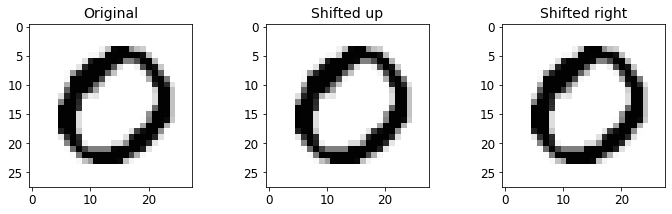

In [117]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted up", fontsize=14)
plt.imshow(s_image_u.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted right", fontsize=14)
plt.imshow(s_image_r.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for image, label in zip(X_train, y_train):
    X_train_augmented.append(move_left(image))
    X_train_augmented.append(move_right(image))
    X_train_augmented.append(move_up(image))
    X_train_augmented.append(move_down(image))
    for k in range(3):
        y_train_augmented.append(label)